# 1. Data Import

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('creditcard.csv')

# No null value:
df.isnull().sum().any()

np.False_

In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
len(df)

284807

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# FEATURE SCALING EXPLANATION:
#   - Using RobustScaler for Amount is recommended because:
#     1. Transaction amounts often contain extreme outliers (e.g., very large purchases)
#     2. RobustScaler uses median and IQR (Interquartile Range), making it resistant to outliers

df['scaled_amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [6]:
# We can see that the data is very imbalanced
print(f'Fraudulent numbers:{df['Class'].value_counts()[0]} / {len(df['Class'])}')

Fraudulent numbers:284315 / 284807


# 2. Under Sampling and Logistic Regression

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = df.drop(['Class'], axis=1)
y = df['Class']

X_base, X_test, y_base, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = pd.concat([X_base, y_base], axis=1)
df_normal_train = df_train[df_train['Class']==0]
df_fraud_train = df_train[df_train['Class']==1]
df_normal_sampled = df_normal_train.sample(n=len(df_fraud_train), random_state=42)
df_balanced = pd.concat([df_normal_sampled, df_fraud_train])

X_resample = df_balanced.drop(['Class'], axis=1)
y_resample = df_balanced['Class']

model = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    random_state=42,
    penalty='l1',
)

model.fit(X_resample, y_resample)


LogisticRegression(max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

In [21]:
print(len(y_resample))

788


In [8]:
# Dataset volume 284807
# Normal : Fraud = 284315 : 492
# Train_Resampled = 788
# y_pred = 56962
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Evaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

TN, FP, FN, TP = conf_matrix.ravel()
fraud_recall = TP / (TP + FN)  # True Positive Rate (Sensitivity)
fraud_precision = TP / (TP + FP)  # Positive Predictive Value
f1_score = 2 * (fraud_precision * fraud_recall) / (fraud_precision + fraud_recall)

print(f"\nFraud-Specific Metrics:")
print(f"Recall (Sensitivity): {fraud_recall:.4f} - Ability to detect actual frauds")
print(f"Precision: {fraud_precision:.4f} - Accuracy when predicting fraud")
print(f"F1-Score: {f1_score:.4f} - Balance between precision and recall")
print(f"False Positive Rate: {FP/(FP+TN):.4f} - Normal transactions misclassified as fraud")


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98     56864
       Fraud       0.04      0.93      0.08        98

    accuracy                           0.97     56962
   macro avg       0.52      0.95      0.53     56962
weighted avg       1.00      0.97      0.98     56962


Confusion Matrix:
[[54906  1958]
 [    7    91]]

Fraud-Specific Metrics:
Recall (Sensitivity): 0.9286 - Ability to detect actual frauds
Precision: 0.0444 - Accuracy when predicting fraud
F1-Score: 0.0848 - Balance between precision and recall
False Positive Rate: 0.0344 - Normal transactions misclassified as fraud


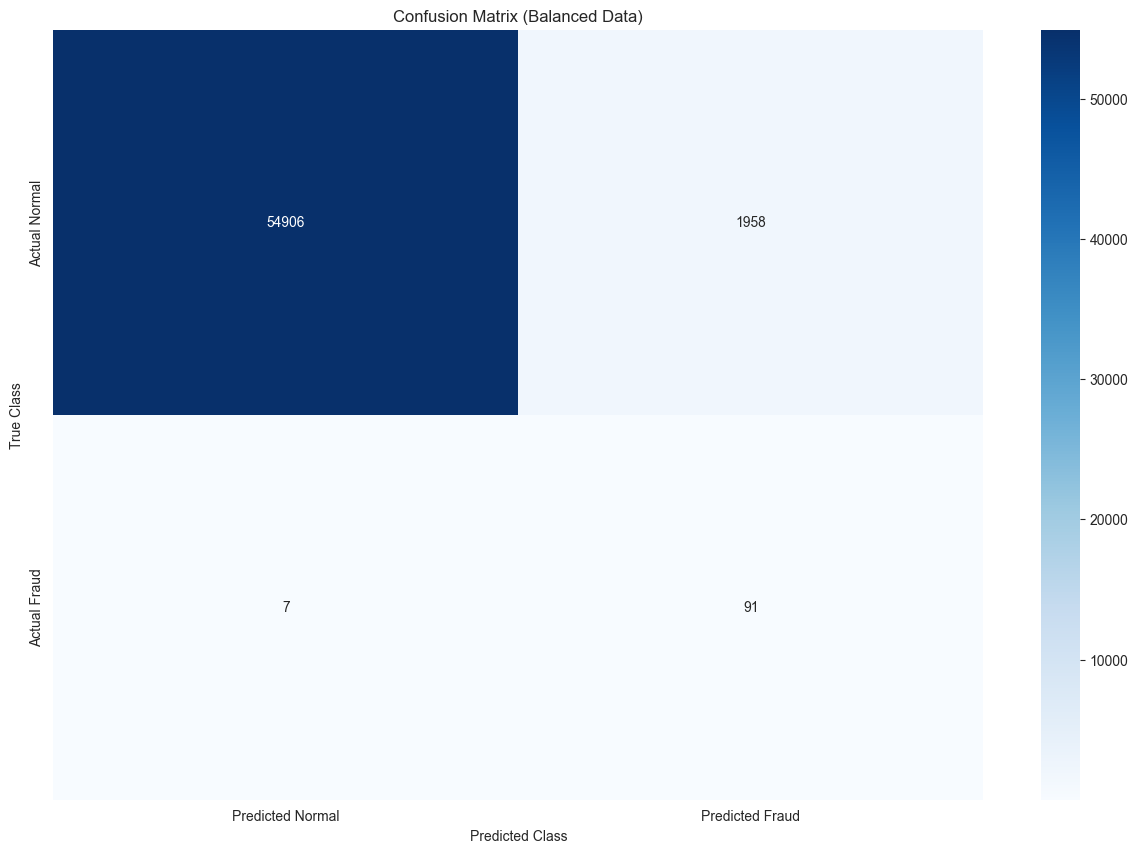

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# Confusion Matrix Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Fraud'],
            yticklabels=['Actual Normal', 'Actual Fraud'])
plt.title('Confusion Matrix (Balanced Data)')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.show()

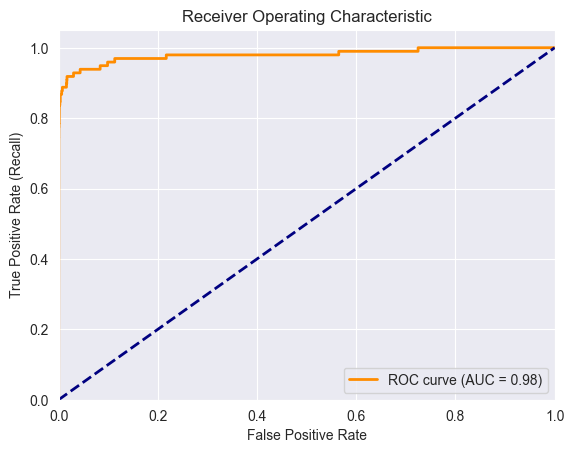

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

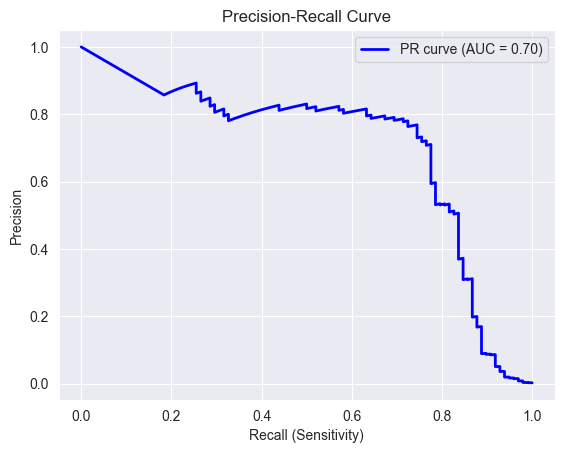

In [11]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

/var/folders/rf/fk21z0nj7wvc4x6py1jjp8dm0000gn/T/ipykernel_67838/1691056622.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


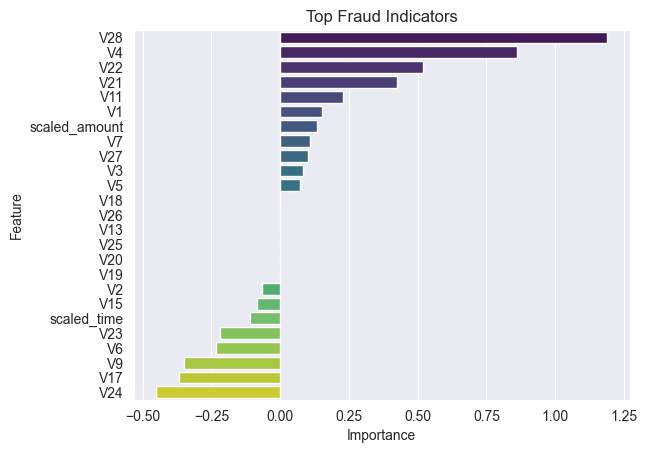

In [12]:
feature_importance = pd.DataFrame({
    'Feature': X_resample.columns,
    'Importance': model.coef_[0]
}).sort_values('Importance', ascending=False)

# Only show top 10 most important features
top_features = feature_importance.head(25)
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top Fraud Indicators')
plt.show()

In [14]:
thresholds = np.arange(0.1, 1.0, 0.05)
results = []

for thresh in thresholds:
    # Convert probabilities to class predictions using threshold
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_thresh)
    TN, FP, FN, TP = conf_matrix.ravel()

    # Calculate metrics
    recall = TP / (TP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr = FP / (FP + TN)

    results.append({
        'Threshold': thresh,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'FPR': fpr
    })

# Create results dataframe
results_df = pd.DataFrame(results)
print("\nPerformance at Different Thresholds:")
print(results_df[['Threshold', 'Recall', 'Precision', 'F1-Score', 'FPR']].to_string(index=False))

# Find optimal threshold based on F1-score
optimal_row = results_df.iloc[results_df['F1-Score'].idxmax()]
print(f"\nOptimal Threshold (Max F1-Score): {optimal_row['Threshold']:.2f}")
print(f"At this threshold:")
print(f"- Recall: {optimal_row['Recall']:.4f}")
print(f"- Precision: {optimal_row['Precision']:.4f}")
print(f"- F1-Score: {optimal_row['F1-Score']:.4f}")
print(f"- False Positive Rate: {optimal_row['FPR']:.4f}")


Performance at Different Thresholds:
 Threshold   Recall  Precision  F1-Score      FPR
      0.10 0.979592   0.007125  0.014148 0.235245
      0.15 0.969388   0.010221  0.020228 0.161790
      0.20 0.969388   0.013720  0.027058 0.120094
      0.25 0.948980   0.017200  0.033787 0.093451
      0.30 0.938776   0.021385  0.041818 0.074036
      0.35 0.938776   0.025520  0.049689 0.061779
      0.40 0.938776   0.031229  0.060447 0.050190
      0.45 0.928571   0.037037  0.071233 0.041608
      0.50 0.928571   0.044412  0.084769 0.034433
      0.55 0.918367   0.051224  0.097035 0.029316
      0.60 0.918367   0.059721  0.112150 0.024919
      0.65 0.918367   0.071034  0.131868 0.020699
      0.70 0.918367   0.082721  0.151771 0.017551
      0.75 0.887755   0.092161  0.166987 0.015071
      0.80 0.887755   0.111111  0.197503 0.012240
      0.85 0.887755   0.147208  0.252540 0.008863
      0.90 0.867347   0.197216  0.321361 0.006085
      0.95 0.867347   0.287162  0.431472 0.003711

Optimal Thr

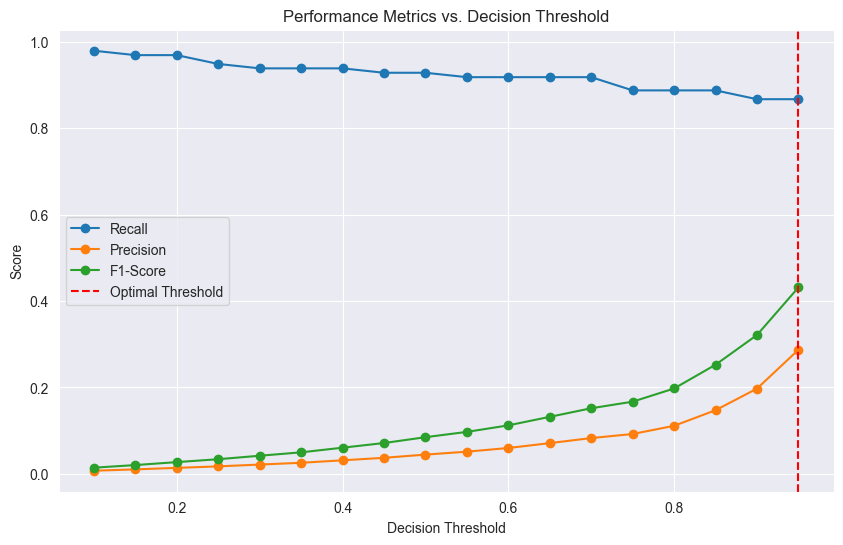

In [15]:
# Plot threshold analysis
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='o')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='o')
plt.axvline(x=optimal_row['Threshold'], color='r', linestyle='--', label='Optimal Threshold')
plt.title('Performance Metrics vs. Decision Threshold')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()